In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import lumos.conversions
import lumos.brdf.library
import lumos.calculator
import lumos.plot
import satellite_models.starlink_v1p5 as starlink_v1p5
import satellite_models.starlink_v1p5_1 as starlink_v1p5_1
import satellite_models.diffuse_sphere as diffuse_sphere_model
import csv
import pandas as pd
import scipy.optimize
from lumos.geometry import Surface
import astropy.time
import astropy.coordinates
from lumos.brdf.library import BINOMIAL, PHONG


In [2]:
# Define the file path
csv_file_path = 'Data.csv'
#initialize the variable
norad_id=[]
sat_name=[]
sat_model=[]
img_start=[]
img_end=[]
loc=[]
v_mag=[]
v_mag_error=[]
exp_photon_flux=[]
effective_albedo=[]
ra_astro=[]
dec_astro=[]
tle_source=[]
ra=[]
dec=[]
pos_error=[]
ele=[]
azi=[]
vel_deg_sec=[]
airmass=[]
orbit_height=[]
ranges=[]
solar_elongation=[]
sun_ele=[]
sun_azi=[]



# Open the CSV file
with open(csv_file_path, 'r') as file:
    # Create a CSV reader object
    csv_reader = csv.reader(file)
    next(csv_reader, None)

    # Read and process the data row by row
    for row in csv_reader:
        # Each row is a list of values
        norad_id_1=int(row[0])
        sat_name_1=row[1]
        sat_model_1=row[2]
        img_start_1=row[3]
        img_end_1=row[4]
        loc_1=row[5]
        v_mag_1=float(row[6])
        v_mag_error_1=float(row[7])
        exp_photon_flux_1=float(row[8])
        effective_albedo_1=float(row[9])
        ra_astro_1=float(row[10])
        dec_astro_1=float(row[11])
        tle_source_1=row[12]
        ra_1=float(row[13])
        dec_1=float(row[14])
        pos_error_1=float(row[15])
        ele_1=float(row[16])
        azi_1=float(row[17])
        vel_deg_sec_1=float(row[18])
        airmass_1=float(row[19])
        orbit_height_1=float(row[20])
        ranges_1=float(row[21])
        solar_elongation_1=float(row[22])
        sun_ele_1=float(row[23])
        sun_azi_1=float(row[24])
        
        norad_id.append(norad_id_1)
        sat_name.append(sat_name_1)
        sat_model.append(sat_model_1)
        img_start.append(img_start_1)
        img_end.append(img_end_1)
        loc.append(loc_1)
        v_mag.append(v_mag_1)
        v_mag_error.append(v_mag_error_1)
        exp_photon_flux.append(exp_photon_flux_1)
        effective_albedo.append(effective_albedo_1)
        ra_astro.append(ra_astro_1)
        dec_astro.append(dec_astro_1)
        tle_source.append(tle_source_1)
        ra.append(ra_1)
        dec.append(dec_1)
        pos_error.append(pos_error_1)
        ele.append(ele_1)
        azi.append(azi_1)
        vel_deg_sec.append(vel_deg_sec_1)
        airmass.append(airmass_1)
        orbit_height.append(orbit_height_1)
        ranges.append(ranges_1)
        solar_elongation.append(solar_elongation_1)
        sun_ele.append(sun_ele_1)
        sun_azi.append(sun_azi_1)



In [3]:
CzenithArea=1    #m^2
CAdjecentArea=1.3    #m^2
SolararryArea=1.5

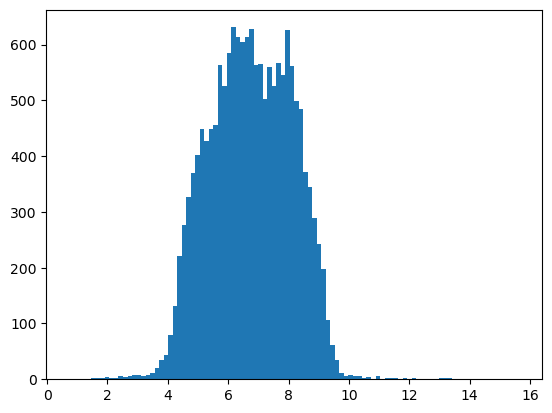

In [4]:
#print(v_mag)
plt.hist(v_mag,bins=100)
plt.show() 

In [5]:
sv1_0=[]
for i in range(0,len(sat_model)):
    if sat_model[i]=="STARLINK v1.0 DARKSAT":
        sv1_0.append(i)
        


In [6]:
sv1_0_indices = [int(index) for index in sv1_0]

satellite_heights = [1000 * orbit_height[index] for index in sv1_0_indices]
satellite_altitudes = [ele[index] for index in sv1_0_indices]
satellite_azimuths =[azi[index] for index in sv1_0_indices]
measured_magnitudes=[v_mag[index] for index in sv1_0_indices]

mount_lemmon = astropy.coordinates.EarthLocation(lat = 32.44257, lon = -110.7889)
Biosphere=astropy.coordinates.EarthLocation(lat = 32.58057, lon = -110.8490)
sun_alts = [sun_ele[index] for index in sv1_0_indices]
sun_azs = [sun_azi[index] for index in sv1_0_indices]


In [7]:
print(len(sv1_0_indices))
print(len(satellite_heights))
print(len(satellite_altitudes))
print(len(satellite_azimuths))
print(len(measured_magnitudes))
print(len(sun_alts))
print(len(sun_azs))

53
53
53
53
53
53
53


In [8]:
def get_earthshine_panels(sat_z, angle_past_terminator, density):
    """
    Creates a mesh of pixels on Earth's surface which are visible to the satellite and illuminated
    by the sun.

    :param sat_z: The height of the satellite above the center of Earth (meters)
    :type sat_z: float
    :param angle_past_terminator: The angle of the satellite past the terminator (radians)
    :type angle_past_terminator: float
    :param density: The density of the pixels. Grid will have size density x density.
    :type density: int
    :returns: 
        - (x, y, z) - Positions of pixels (meters)
        - (nx, ny, nz) - Normal vectors of pixels
        - areas - Areas of pixels (:math:`m^2`)
    """

    R = lumos.constants.EARTH_RADIUS

    max_angle = np.arccos(R / sat_z)

    angles_off_plane = np.linspace(-max_angle, max_angle, density)
    angles_on_plane = np.linspace(angle_past_terminator, max_angle, density)

    d_phi = abs( angles_off_plane[1] - angles_off_plane[0] )
    d_theta = abs( angles_on_plane[1] - angles_on_plane[0] )

    angles_on_plane, angles_off_plane = np.meshgrid(angles_on_plane, angles_off_plane)
    angles_on_plane, angles_off_plane = angles_on_plane.flatten(), angles_off_plane.flatten()

    # Set up panel positions
    nz = 1 / np.sqrt( 1 + np.tan(angles_on_plane)**2 + np.tan(angles_off_plane)**2 )
    nx = np.tan(angles_off_plane) * nz
    ny = np.tan(angles_on_plane) * nz

    # Clip the panels which aren't visible to the satellite
    visible_to_sat = np.arccos(nz) < max_angle
    angles_off_plane, angles_on_plane = angles_off_plane[visible_to_sat], angles_on_plane[visible_to_sat]
    nx, ny, nz = nx[visible_to_sat], ny[visible_to_sat], nz[visible_to_sat]

    # Calculate Jacobian determinant to get panel areas
    x, y, z = nx * R, ny * R, nz * R

    phi = angles_off_plane
    theta = angles_on_plane
        
    dx_dr = nx / nz * z / R
    dx_dphi = z**3 / (R**2 * np.cos(phi)**2 * np.cos(theta)**2)
    dx_dtheta = - (ny / nz * nx / nz* z**3 ) / (R**2 * np.cos(theta)**2 )
    
    dy_dr = np.tan(theta) * z / R
    dy_dphi = - ( ny / nz * nx / nz * z**3 ) / (R**2 * np.cos(phi)**2 )
    dy_dtheta = dx_dphi
    
    dz_dr = z / R
    dz_dphi = - (nx / nz * z**3 ) / (R**2 * np.cos(phi)**2)
    dz_dtheta = - (ny / nz * z**3 ) / (R**2 * np.cos(theta)**2)

    determinant = (
        dx_dr * (dy_dphi * dz_dtheta - dy_dtheta * dz_dphi) -
        dy_dr * (dx_dphi * dz_dtheta - dx_dtheta * dz_dphi) +
        dz_dr * (dx_dphi * dy_dtheta - dx_dtheta * dy_dphi) )
    
    areas = determinant * d_phi * d_theta
    
    return x, y, z, nx, ny, nz, areas


def get_intensity_satellite_frame(
    sat_surfaces, 
    sat_height, 
    angle_past_terminator,
    observer_position,
    include_sun = True, 
    include_earthshine = True,
    earth_panel_density = 150, 
    earth_brdf = None):
    '''
    Calculates flux scattered by a satellite and seen by an observer.

    :param sat_surfaces: List of surfaces on satellite
    :type sat_surfaces: list[lumos.geometry.Surface]
    :param sat_height: Height of satellite above geodetic nadir (meters)
    :type sat_height: float
    :param angle_past_terminator: Angle of satellite past terminator (radians)
    :type angle_past_terminator: float
    :param observer_position: Position of an observer, measured in brightness frame (meters)
    :type observer_position: :class:`np.ndarray`
    :param include_sun: Whether to include flux scattered by the satellite from the sun
    :type include_sun: bool, optional
    :param include_earthshine: Whether to include flux scattered by the satellite from earthshine
    :type include_earthshine: bool, optional
    :param earth_panel_density: There will be earth_panel_density x earth_panel_density panels in the earthshine mesh
    :type earth_panel_density: int, optional
    :param earth_brdf: A function representing the BRDF of Earth's surface
    :type earth_brdf: function
    :return: Flux of light incident on the observer (W / m^2)
    :rtype: float
    '''
    
    horizon_angle = np.arccos(lumos.constants.EARTH_RADIUS / (lumos.constants.EARTH_RADIUS + sat_height))
    if angle_past_terminator > horizon_angle:
        # Inside earth's shadow
        return 0
    
    observer_x, observer_y, observer_z = observer_position[0], observer_position[1], observer_position[2]

    if np.arccos(observer_z / lumos.constants.EARTH_RADIUS) > horizon_angle + np.deg2rad(1):
        # Not visible to observer
        # Fudging this by 1 degree makes plots much nicer on edges
        return 0

    vector_2_sun = (0, np.cos(angle_past_terminator), - np.sin(angle_past_terminator))

    sat_z = sat_height + lumos.constants.EARTH_RADIUS

    # Distances from observers to satellite
    dist_sat_2_obs = np.sqrt( observer_x**2 + observer_y**2 
                            + (observer_z - sat_z)**2 )
    
    # Unit vectors from observers to satellite
    sat_obs_x = observer_x / dist_sat_2_obs
    sat_obs_y = observer_y / dist_sat_2_obs
    sat_obs_z = (observer_z - sat_z) / dist_sat_2_obs

    if include_earthshine:
        panel_x, panel_y, panel_z, panel_nx, panel_ny, panel_nz, panel_areas = \
            get_earthshine_panels(sat_z, angle_past_terminator, earth_panel_density)
        
        # Distances from earthshine panels to satellite
        dist_panels_2_sat = np.sqrt(panel_x**2 + panel_y**2 + (sat_z - panel_z)**2 )

        panel_sat_x = - panel_x / dist_panels_2_sat
        panel_sat_y = - panel_y / dist_panels_2_sat
        panel_sat_z = (sat_z - panel_z) / dist_panels_2_sat

        # Panel Normalization
        panel_normalizations = (panel_ny * vector_2_sun[1] + panel_nz * vector_2_sun[2])

        panel_brdfs = earth_brdf(vector_2_sun,
                                (panel_nx, panel_ny, panel_nz),
                                (panel_sat_x, panel_sat_y, panel_sat_z))

    intensity = 0

    for surface in sat_surfaces:
        
        if callable(surface.normal):
            surface_normal = surface.normal(angle_past_terminator)
        else:
            surface_normal = surface.normal
        
        sun_contribution = 0
        earth_contribution = 0
        
        surface_normalization = surface_normal[1] * vector_2_sun[1] + surface_normal[2] * vector_2_sun[2]
        surface_normalization = np.clip(surface_normalization, 0, None)

        observer_normalization = surface_normal[0] * sat_obs_x + surface_normal[1] * sat_obs_y + surface_normal[2] * sat_obs_z
        observer_normalization = np.clip(observer_normalization, 0, None)

        if include_sun:
            surface_brdf = surface.brdf(vector_2_sun,
                                        surface_normal,
                                        (sat_obs_x, sat_obs_y, sat_obs_z))

            sun_contribution = sun_contribution + surface_brdf * surface_normalization * observer_normalization

        if include_earthshine:

            surface_normalizations = np.clip(
                - surface_normal[0] * panel_sat_x \
                - surface_normal[1] * panel_sat_y \
                - surface_normal[2] * panel_sat_z,
                0,
                None
            )

            panel_observing_normalization = np.clip(
                panel_nx * panel_sat_x
                + panel_ny * panel_sat_y
                + panel_nz * panel_sat_z,
                0,
                None
            )

            surface_brdf = surface.brdf( (-panel_sat_x, -panel_sat_y, -panel_sat_z),
                                          surface_normal,
                                         (sat_obs_x, sat_obs_y, sat_obs_z) )
            
            earth_contribution = earth_contribution \
                  + np.sum(panel_brdfs * surface_brdf 
                         * panel_normalizations * observer_normalization 
                         * surface_normalizations * panel_observing_normalization
                         * panel_areas / dist_panels_2_sat**2 )
        
        intensity = intensity + lumos.constants.SUN_INTENSITY * surface.area * (sun_contribution + earth_contribution) / dist_sat_2_obs ** 2

    return intensity


def get_brightness_coords(
    sat_alt, 
    sat_az, 
    sat_height, 
    sun_alt, 
    sun_az):
    """
    Converts from HCS observer coordinates to brightness coordinates.

    :param sat_alt: Altitude of satellite (degrees)
    :type sat_alt: float or :class:`np.ndarray`
    :param sat_az: Altitude of satellite (degrees)
    :type sat_az: float or :class:`np.ndarray`
    :param sat_height: Geodetic height of satellite (meters)
    :type sat_height: float or :class:`np.ndarray`
    :param sun_alt: Altitude of sun (degrees)
    :type sun_alt: float
    :param sun_az: Azimuth angle of sun (degrees)
    :type sun_az: float
    :returns:
        - (obs_x, obs_y, obs_z) - Vector from satellite to observer in brightness frame (meters)
        - angle_past_terminator - Angle of satellite past terminator (radians)
    """

    sat_x, sat_y, sat_z = lumos.conversions.altaz_to_unit(sat_alt, sat_az)
    sun_x, sun_y, sun_z = lumos.conversions.altaz_to_unit(sun_alt, sun_az)

    phi = np.arccos(sat_z) - np.arcsin(lumos.constants.EARTH_RADIUS / (lumos.constants.EARTH_RADIUS + sat_height) * np.sqrt(sat_x**2 + sat_y**2) )
    theta = np.arctan2(sat_y, sat_x)

    Zx = np.sin(phi) * np.cos(theta)
    Zy = np.sin(phi) * np.sin(theta)
    Zz = np.cos(phi)

    dot = Zx * sun_x + Zy * sun_y + Zz * sun_z
    beta = 1 / np.sqrt(1 - dot**2)
    alpha = - beta * dot

    Yx = alpha * Zx + beta * sun_x
    Yy = alpha * Zy + beta * sun_y
    Yz = alpha * Zz + beta * sun_z

    flip = np.sign(Yx * sun_x + Yy * sun_y + Yz * sun_z)
    Yx, Yy, Yz = flip * Yx, flip * Yy, flip * Yz

    Xx = Yy * Zz - Zy * Yz
    Xy = Zx * Yz - Yx * Zz
    Xz = Yx * Zy - Zx * Yy

    T11, T12, T13, \
    T21, T22, T23, \
    T31, T32, T33  = lumos.functions.inv_3(Xx, Yx, Zx, 
                                           Xy, Yy, Zy, 
                                           Xz, Yz, Zz)
    
    dist_to_sat = np.sqrt(lumos.constants.EARTH_RADIUS**2 
    + (lumos.constants.EARTH_RADIUS + sat_height)**2 
    - 2 * lumos.constants.EARTH_RADIUS * (lumos.constants.EARTH_RADIUS + sat_height) * np.cos(phi))

    obs_x = - dist_to_sat * (T11 * sat_x + T12 * sat_y + T13 * sat_z)
    obs_y = - dist_to_sat * (T21 * sat_x + T22 * sat_y + T23 * sat_z)
    obs_z = (lumos.constants.EARTH_RADIUS + sat_height) - dist_to_sat * (T31 * sat_x + T32 * sat_y + T33 * sat_z)

    angle_past_terminator = -np.arcsin(T31 * sun_x + T32 * sun_y + T33 * sun_z)

    return obs_x, obs_y, obs_z, angle_past_terminator


def get_intensity_observer_frame(
    sat_surfaces, 
    sat_heights, 
    sat_altitudes, 
    sat_azimuths,
    sun_altitude,
    sun_azimuth,
    include_sun = True,
    include_earthshine = True,
    earth_panel_density = 150,
    earth_brdf = None):

    """
    Calculates the flux of a satellite seen by an observer.

    :param sat_surfaces: List of surfaces on satellite
    :type sat_surfaces: list[lumos.geometry.Surface]
    :param sat_heights: Heights of satellite above geodetic nadir (meters)
    :type sat_heights: float or :class:`np.ndarray`
    :param sat_altitudes: Satellite altitudes in HCS frame (degrees)
    :type sat_altitudes: float or :class:`np.ndarray`
    :param sat_azimuths: Satellite azimuths in HCS frame (degrees)
    :type sat_azimuths: float or :class:`np.ndarray`
    :param sun_altitude: Altitude of sun in HCS frame (degrees)
    :type sun_altitude: float
    :param sun_azimuth: Azimuth of sun in HCS frame (degrees)
    :type sun_azimuth: float
    :param include_sun: Whether to include flux scattered by the satellite from the sun
    :type include_sun: bool, optional
    :param include_earthshine: Whether to include flux scattered by the satellite from earthshine
    :type include_earthshine: bool, optional
    :param earth_panel_density: There will be earth_panel_density x earth_panel_density panels in the earthshine mesh
    :type earth_panel_density: int, optional
    :param earth_brdf: A function representing the BRDF of Earth's surface
    :type earth_brdf: function
    :return: Flux of light incident on the observer (W / m^2)
    :rtype: float or :class:`np.ndarray`
    """
    
    if sun_altitude > 0:
        raise ValueError(f"Observatory is in daylight! Sun Altitude = {sun_altitude}")
    
    sat_alts, sat_azs = np.asarray(sat_altitudes), np.asarray(sat_azimuths)
    output_shape = sat_alts.shape

    if not isinstance(sat_heights, np.ndarray):
        sat_heights = sat_heights * np.ones(output_shape)

    sat_heights, sat_alts, sat_azs = sat_heights.flatten(), sat_alts.flatten(), sat_azs.flatten()
    intensity = np.zeros_like(sat_alts)

    obs_x, obs_y, obs_z, angle_past_terminator = get_brightness_coords(sat_alts, sat_azs, sat_heights, 
        sun_altitude, sun_azimuth)

    for (i, (x, y, z, alpha, h)) in enumerate(zip(obs_x, obs_y, obs_z, angle_past_terminator, sat_heights)):
        intensity[i] = get_intensity_satellite_frame(
            sat_surfaces, h, alpha, (x, y, z),
            include_sun, include_earthshine, earth_panel_density, earth_brdf)

    intensity = intensity.reshape(output_shape)
    return intensity

In [9]:
def optimization(params):

    p1, p2, p3, p4, p5, p6 = params

    calculated_intensities = np.zeros_like(measured_magnitudes)

    # Sets up surfaces of satellite, one for the chassis and one for the solar array
    # Phong parameters, p1 - p6 vary
    surfaces = [
        Surface(1.0, np.array([0, 0, -1]), lumos.brdf.library.PHONG(p1, p2, p3)),
        Surface(1.0, np.array([0, 0, 1]), lumos.brdf.library.PHONG(p1, p2, p3)),
        Surface(1.0, np.array([0, -1, 0]), lumos.brdf.library.PHONG(p1, p2, p3)),
        Surface(1.0, np.array([0, 1, 0]), lumos.brdf.library.PHONG(p1, p2, p3)),
        Surface(1.0, np.array([1, 0, 0]), lumos.brdf.library.PHONG(p1, p2, p3)),
        Surface(1.0, np.array([-1, 0, 0]), lumos.brdf.library.PHONG(p1, p2, p3)),
        Surface(1.0, np.array([0, 1, 0]), lumos.brdf.library.PHONG(p4, p5, p6))
        ]

    # Calculates predicted AB Mag for every observation
    for i, (sat_alt, sat_az, sat_h, sun_alt, sun_az) \
        in enumerate(zip(satellite_altitudes, satellite_azimuths, satellite_heights, sun_alts, sun_azs)):

        
        calculated_intensities[i] = get_intensity_observer_frame(
            surfaces,
            sat_h,
            sat_alt,
            sat_az,
            sun_alt,
            sun_az,
            include_sun = True,
            include_earthshine = False
            )
    
    calculated_magnitudes = lumos.conversions.intensity_to_ab_mag(calculated_intensities)

    # Return RMS between prediction and actual observation
    error = calculated_magnitudes - measured_magnitudes
    rms = np.sqrt( np.mean( error**2 ) )
    return rms

sol = scipy.optimize.minimize(
    optimization,
    x0 = (1, 1, 1, 1, 1, 1),
    bounds = ( (0, 20), (0, 20), (0, 200), 
               (0, 20), (0, 20), (0, 200)) )

Kd11, Ks11, n11, Kd21, Ks21, n21 = sol.x
print(f"RMS = {sol.fun:0.3f}")

RMS = 0.897


In [10]:
print("Chassis Inferred BRDF Parameters")
print("------------------------------------")
print(f"Kd = {Kd11:0.2f}")
print(f"Ks = {Ks11:0.2f}")
print(f"n = {n11:0.2f}")

print("Solar Array Inferred BRDF Parameters")
print("------------------------------------")
print(f"Kd = {Kd21:0.2f}")
print(f"Ks = {Ks21:0.2f}")
print(f"n = {n21:0.2f}")

Chassis Inferred BRDF Parameters
------------------------------------
Kd = 0.20
Ks = 0.21
n = 1.97
Solar Array Inferred BRDF Parameters
------------------------------------
Kd = 0.11
Ks = 1.05
n = 3.03


In [11]:
def optimization(params):

    p1, p2, p3, p4, p5, p6 = params

    calculated_intensities = np.zeros_like(measured_magnitudes)

    # Sets up surfaces of satellite, one for the chassis and one for the solar array
    # Phong parameters, p1 - p6 vary
    surfaces = [
        Surface(1.0, np.array([0, 0, -1]), lumos.brdf.library.PHONG(p1, p2, p3)),
        Surface(1.0, np.array([0, 1, 0]), lumos.brdf.library.PHONG(p4, p5, p6))
        ]

    # Calculates predicted AB Mag for every observation
    for i, (sat_alt, sat_az, sat_h, sun_alt, sun_az) \
        in enumerate(zip(satellite_altitudes, satellite_azimuths, satellite_heights, sun_alts, sun_azs)):

        calculated_intensities[i] = lumos.calculator.get_intensity_observer_frame(
            surfaces,
            sat_h,
            sat_alt,
            sat_az,
            sun_alt,
            sun_az,
            include_sun = True,
            include_earthshine = False
            )
    
    calculated_magnitudes = lumos.conversions.intensity_to_ab_mag(calculated_intensities)

    # Return RMS between prediction and actual observation
    error = calculated_magnitudes - measured_magnitudes
    rms = np.sqrt( np.mean( error**2 ) )
    return rms

sol = scipy.optimize.minimize(
    optimization,
    x0 = (1, 1, 1, 1, 1, 1),
    bounds = ( (0, 20), (0, 20), (0, 200), 
               (0, 20), (0, 20), (0, 200)) )

Kd12, Ks12, n12, Kd22, Ks22, n22 = sol.x
print(f"RMS = {sol.fun:0.3f}")

RMS = 0.897


In [12]:
print("Chassis Inferred BRDF Parameters")
print("------------------------------------")
print(f"Kd = {Kd12:0.2f}")
print(f"Ks = {Ks12:0.2f}")
print(f"n = {n12:0.2f}")

print("Solar Array Inferred BRDF Parameters")
print("------------------------------------")
print(f"Kd = {Kd22:0.2f}")
print(f"Ks = {Ks22:0.2f}")
print(f"n = {n22:0.2f}")

Chassis Inferred BRDF Parameters
------------------------------------
Kd = 0.18
Ks = 0.23
n = 1.71
Solar Array Inferred BRDF Parameters
------------------------------------
Kd = 0.32
Ks = 1.32
n = 2.94


In [13]:
satellite_height = np.mean(orbit_height) * 1000

altitudes = np.linspace(0, 90, 45)
azimuths = np.linspace(0, 360, 90)
altitudes, azimuths = np.meshgrid(altitudes, azimuths)

sun_azimuth = 90

In [14]:
def plot_intensity(ax, sun_altitude, surfaces, earth_brdf = None, diffuse_sphere = False, filter = False):

    if diffuse_sphere:
        intensities = diffuse_sphere_model.get_intensity(
            0.65,
            satellite_height,
            altitudes,
            azimuths,
            sun_altitude,
            sun_azimuth)
    else:
        intensities = lumos.calculator.get_intensity_observer_frame(
            surfaces,
            satellite_height,
            altitudes,
            azimuths,
            sun_altitude,
            sun_azimuth,
            include_sun = True,
            include_earthshine = earth_brdf != None,
            earth_panel_density = 251,
            earth_brdf = earth_brdf
        )

    if filter:
        intensities = scipy.ndimage.gaussian_filter(intensities, 2, mode = ('wrap', 'reflect'))

    lumos.plot.contour_observer_frame(
        ax,
        altitudes,
        azimuths,
        lumos.conversions.intensity_to_ab_mag(intensities, clip = True),
        levels = (4, 8),
        cmap = "plasma_r"
    )

    ax.set_title("Sun Altitude" + r"$=$" + f"{sun_altitude}°")

In [15]:
def plot_compass(ax):
    ax.arrow(0, 0, 0, 0.75, width = 0.05, color = "black", head_length = 0.25, head_width = 0.25)
    ax.arrow(0, 0, -0.75, 0, width = 0.05, color = "black", head_length = 0.25, head_width = 0.25)
    ax.scatter([0], [0], s = 350, c = "black", zorder = 1)
    ax.annotate("N", (0, 1.15), horizontalalignment = 'center', 
                    verticalalignment = 'center', fontsize = 24, annotation_clip = False,
                    fontweight = 'bold')
    ax.annotate("E", (-1.15, 0), horizontalalignment = 'center', 
                    verticalalignment = 'center', fontsize = 24, annotation_clip = False,
                    fontweight = 'bold')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

In [16]:
def plot_composite_figure(title, surfaces, earth_brdf = None, diffuse_sphere = False, filter = False):

    fig = plt.figure(figsize = (32, 6), dpi = 300)

    cax = fig.add_axes([0, 0.05, 0.15, 0.75])

    h = 0.8
    w = h * 6 / 32

    ax1 = fig.add_axes([0.5 - w/2 - 2 * (w + 0.0075), 0.025, w, h], projection = 'polar')
    ax2 = fig.add_axes([0.5 - w/2 - 1 * (w + 0.0075), 0.025, w, h], projection = 'polar')
    ax3 = fig.add_axes([0.5 - w/2 + 0 * (w + 0.0075), 0.025, w, h], projection = 'polar')
    ax4 = fig.add_axes([0.5 - w/2 + 1 * (w + 0.0075), 0.025, w, h], projection = 'polar')
    ax5 = fig.add_axes([0.5 - w/2 + 2 * (w + 0.0075), 0.025, w, h], projection = 'polar')
    ax6 = fig.add_axes([0.9, 0, 0.25 * w, 0.25 * h])

    plot_compass(ax6)

    axs = (ax1, ax2, ax3, ax4, ax5)
    sun_altitudes = (-27, -21, -15, -9, -3)

    for ax, sun_alt in zip(axs, sun_altitudes):
        plot_intensity(ax, sun_alt, surfaces, earth_brdf, diffuse_sphere, filter)
        ax.set_title(f"Sun Alt. = {sun_alt}°", y = -0.15, fontsize = 32)
        ax.set_xticklabels(['', '', '', ''])

    fig.suptitle(title, fontsize = 40)

    lumos.plot.colorbar(cax, levels = (4, 8))
    cax.tick_params(labelsize = 28)
    cax.set_ylabel("AB Magnitude", fontsize = 32)
    cax.invert_yaxis()
    cax.yaxis.set_label_position("left")

    plt.show()

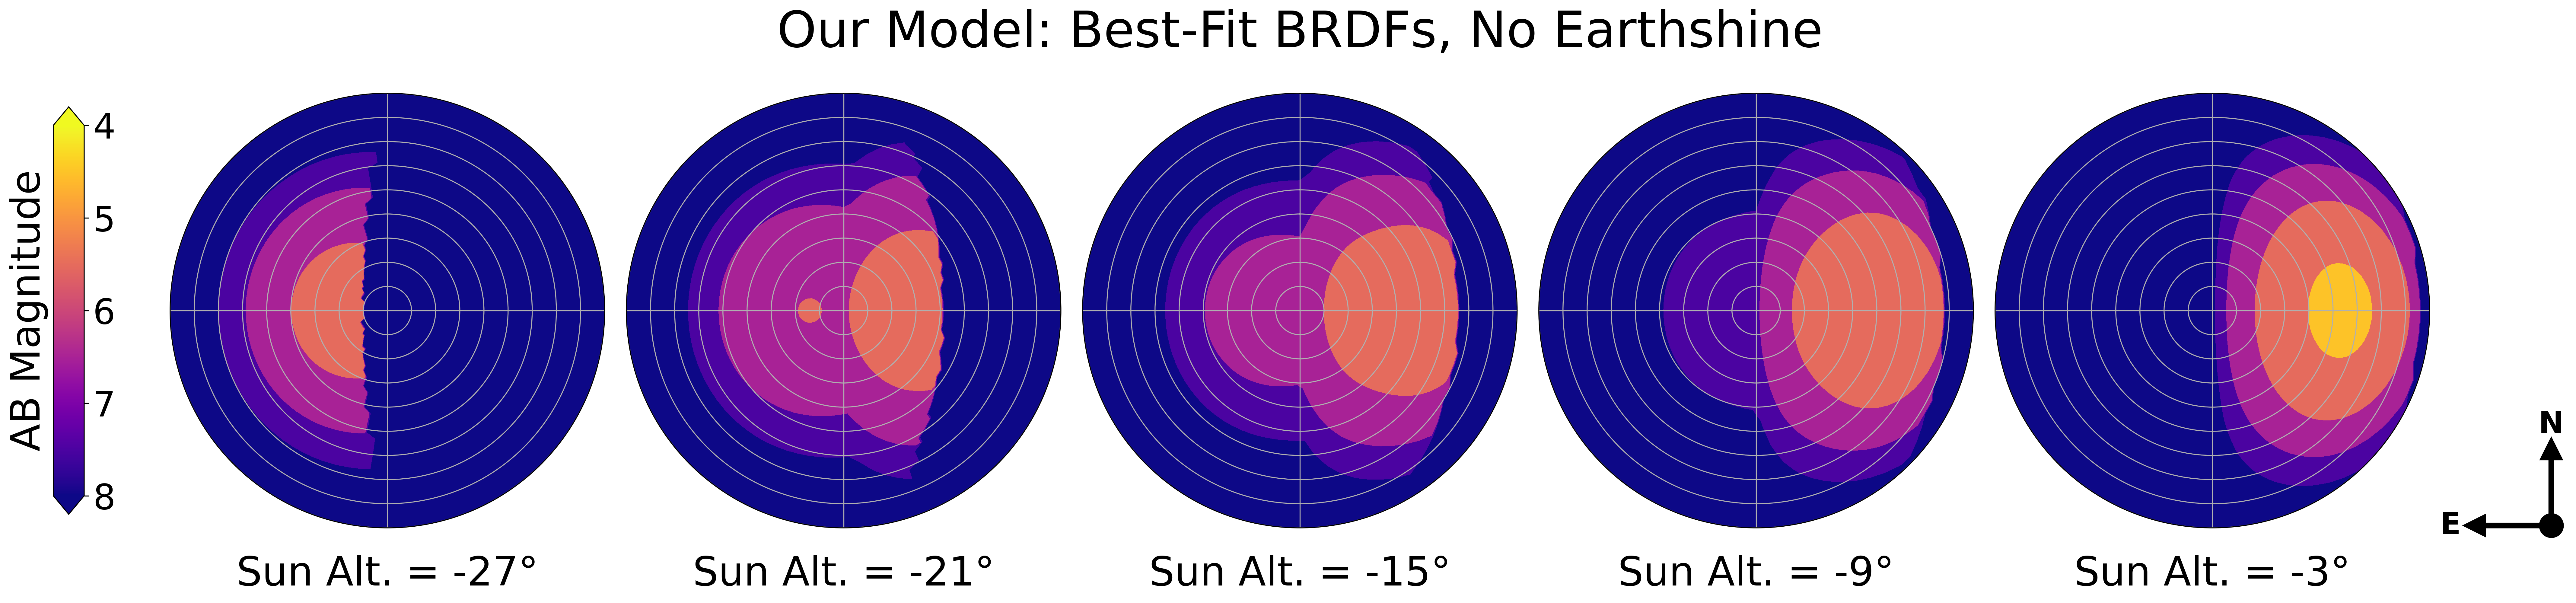

In [17]:
chassis_normal = np.array([0, 0, -1])
solar_array_normal = np.array([0, 1, 0])



plot_composite_figure(
    title = "Our Model: Best-Fit BRDFs, No Earthshine",
    surfaces = [
    Surface(1.0, chassis_normal, PHONG(Kd11,Ks11,n11)),
    Surface(1.0, np.array([0,0,1]), PHONG(Kd11,Ks11,n11)),
    Surface(1.0, np.array([0,1,0]), PHONG(Kd11,Ks11,n11)),
    Surface(1.0, np.array([0,-1,0]), PHONG(Kd11,Ks11,n11)),
    Surface(1.0, np.array([1,0,0]), PHONG(Kd11,Ks11,n11)),
    Surface(1.0, np.array([-1,0,0]), PHONG(Kd11,Ks11,n11)),
    Surface(1.0, solar_array_normal, PHONG(Kd21,Ks21,n21))
]
)


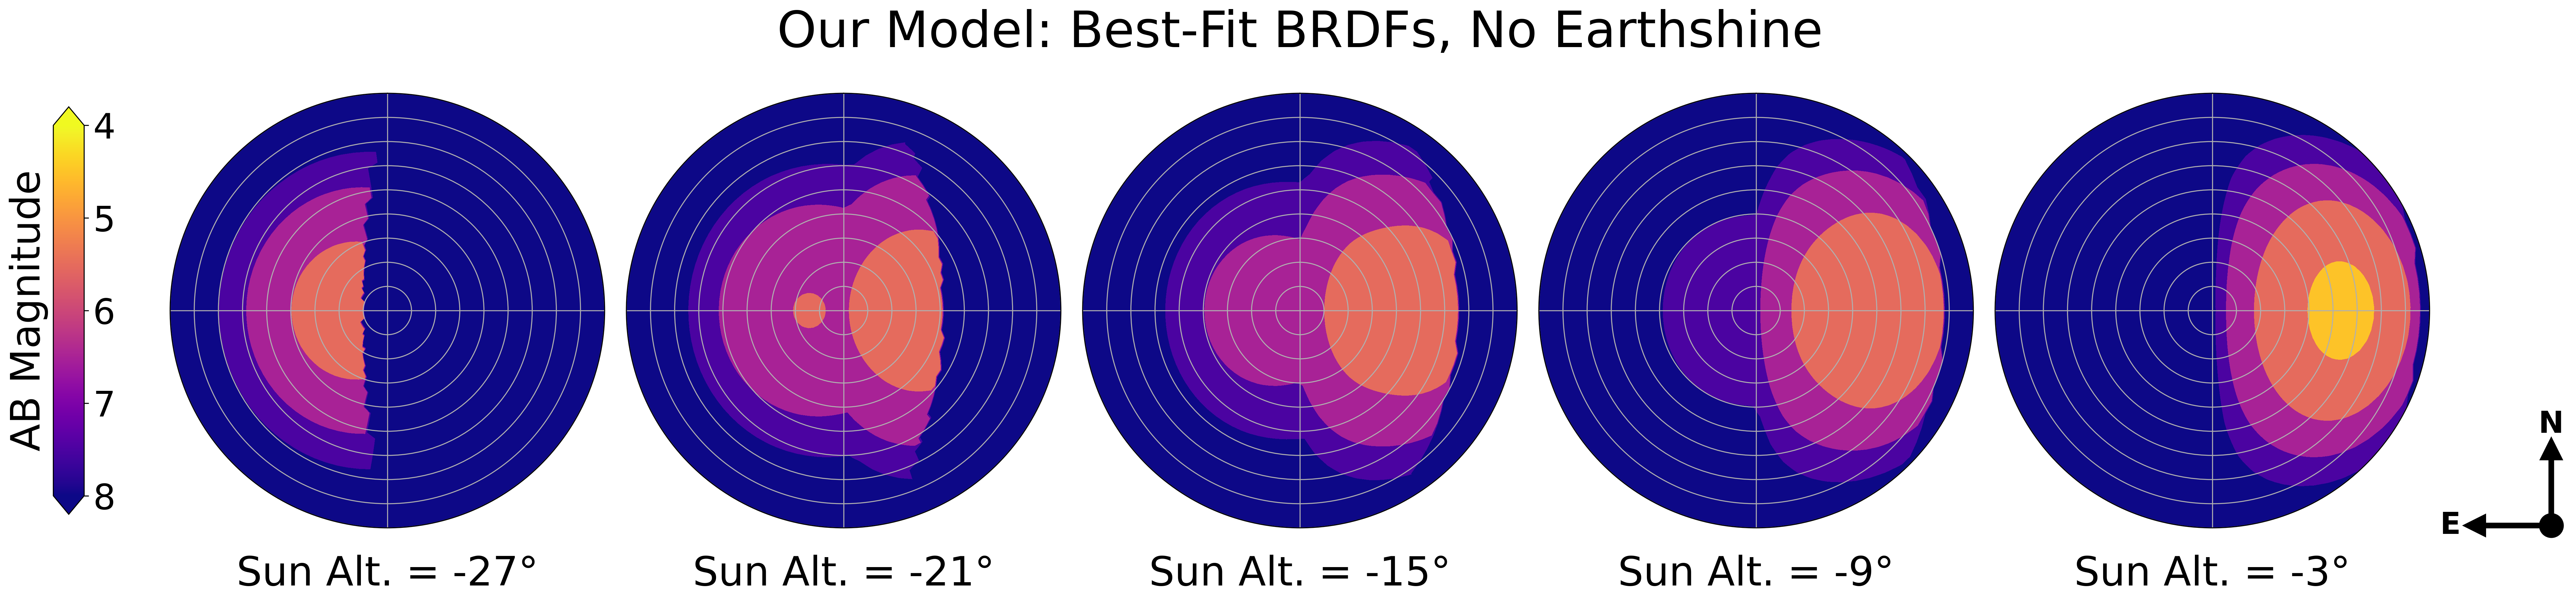

In [18]:
plot_composite_figure(
    title = "Our Model: Best-Fit BRDFs, No Earthshine",
    surfaces = [
    Surface(1.0, chassis_normal, PHONG(Kd12,Ks12,n12)),
    Surface(1.0, solar_array_normal, PHONG(Kd22,Ks22,n22))
]
)

In [19]:
print(len(v_mag))

16247
